
# Exploratory Data Analysis – Credit Default Dataset

This notebook explores the **UCI Credit Default dataset**: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients 

Goal: understand the distribution of defaults vs non-defaults, and key drivers such as demographics, payment history, credit exposure, and repayment behavior.  

We will use this analysis to prepare feature engineering and model building (XGBoost, Deep Learning, MLOps).


## Dataset official description (https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

## 1. Load Dataset  

We first load the dataset from Excel (`credit.xls`).  
The file has a multi-row header which we flatten into single column names for easier processing.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# Load Excel with multi-index header and flatten
data_path = "../data/credit.xls"
df = pd.read_excel(data_path, header=[0,1])
df.columns = ['_'.join([str(x) for x in col if str(x) != 'nan']) for col in df.columns.values]

print("Shape:", df.shape)
df.head()


Shape: (30000, 25)


,Unnamed: 0_level_0_ID,X1_LIMIT_BAL,X2_SEX,X3_EDUCATION,X4_MARRIAGE,X5_AGE,X6_PAY_0,X7_PAY_2,X8_PAY_3,X9_PAY_4,...,X15_BILL_AMT4,X16_BILL_AMT5,X17_BILL_AMT6,X18_PAY_AMT1,X19_PAY_AMT2,X20_PAY_AMT3,X21_PAY_AMT4,X22_PAY_AMT5,X23_PAY_AMT6,Y_default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



## 2. Dataset Overview  

Quick checks of the dataset to confirm structure, missing values, datatypes, and summary statistics.  
This step ensures data consistency before deeper exploration.


In [2]:

print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
df.info()
df.describe().T



Columns: ['Unnamed: 0_level_0_ID', 'X1_LIMIT_BAL', 'X2_SEX', 'X3_EDUCATION', 'X4_MARRIAGE', 'X5_AGE', 'X6_PAY_0', 'X7_PAY_2', 'X8_PAY_3', 'X9_PAY_4', 'X10_PAY_5', 'X11_PAY_6', 'X12_BILL_AMT1', 'X13_BILL_AMT2', 'X14_BILL_AMT3', 'X15_BILL_AMT4', 'X16_BILL_AMT5', 'X17_BILL_AMT6', 'X18_PAY_AMT1', 'X19_PAY_AMT2', 'X20_PAY_AMT3', 'X21_PAY_AMT4', 'X22_PAY_AMT5', 'X23_PAY_AMT6', 'Y_default payment next month']

Missing values:
 Unnamed: 0_level_0_ID           0
X1_LIMIT_BAL                    0
X2_SEX                          0
X3_EDUCATION                    0
X4_MARRIAGE                     0
X5_AGE                          0
X6_PAY_0                        0
X7_PAY_2                        0
X8_PAY_3                        0
X9_PAY_4                        0
X10_PAY_5                       0
X11_PAY_6                       0
X12_BILL_AMT1                   0
X13_BILL_AMT2                   0
X14_BILL_AMT3                   0
X15_BILL_AMT4                   0
X16_BILL_AMT5                  

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0_level_0_ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
X1_LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
X2_SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
X3_EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
X4_MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
X5_AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
X6_PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
X7_PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
X8_PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
X9_PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0



## 3. Target Variable Distribution  

The target variable is `Y_default payment next month`.  
- 1 = client defaulted  
- 0 = client did not default  

This is the outcome we want to predict. Checking class balance is crucial: imbalanced data can bias models and requires careful evaluation (precision, recall, AUC).  


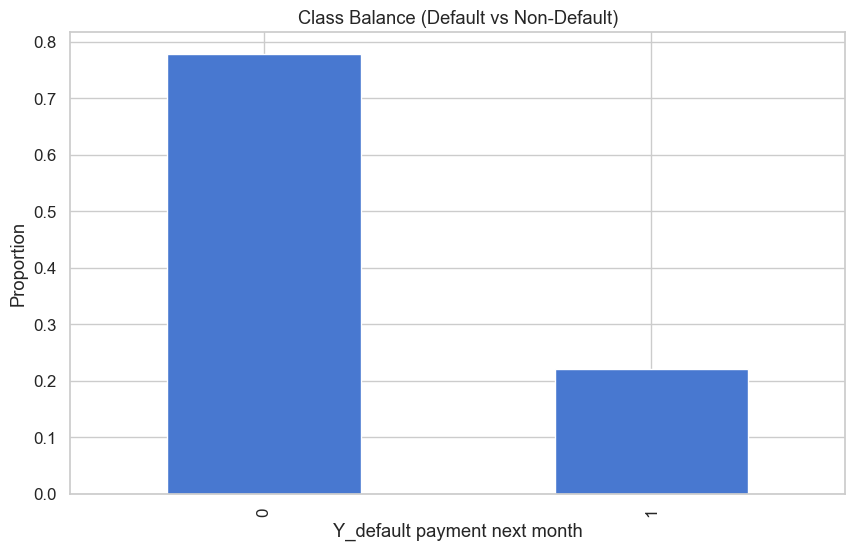

In [3]:
TARGET = "Y_default payment next month"

df[TARGET].value_counts(normalize=True).plot(
    kind="bar",
    title="Class Balance (Default vs Non-Default)"
)
plt.ylabel("Proportion")
plt.show()



## 4. Demographics  

We analyze demographic variables:  
- `X2_SEX` (1 = male, 2 = female)  
- `X3_EDUCATION` (1 = graduate, 2 = university, 3 = high school, 4–6 = other/unknown)  
- `X4_MARRIAGE` (1 = married, 2 = single, 3 = other)  
- `X5_AGE` (client age in years)  

Plots show the **percentage of defaults within each category**. Age is binned into ranges for interpretability.  


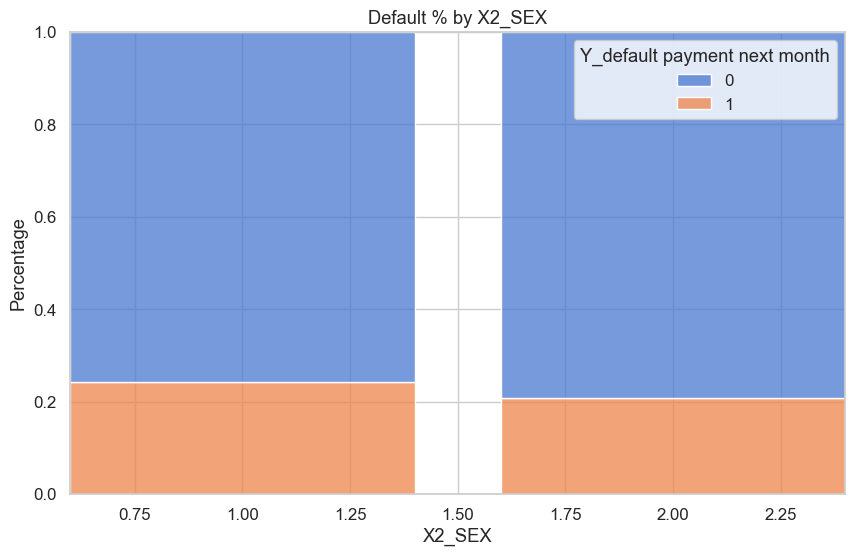

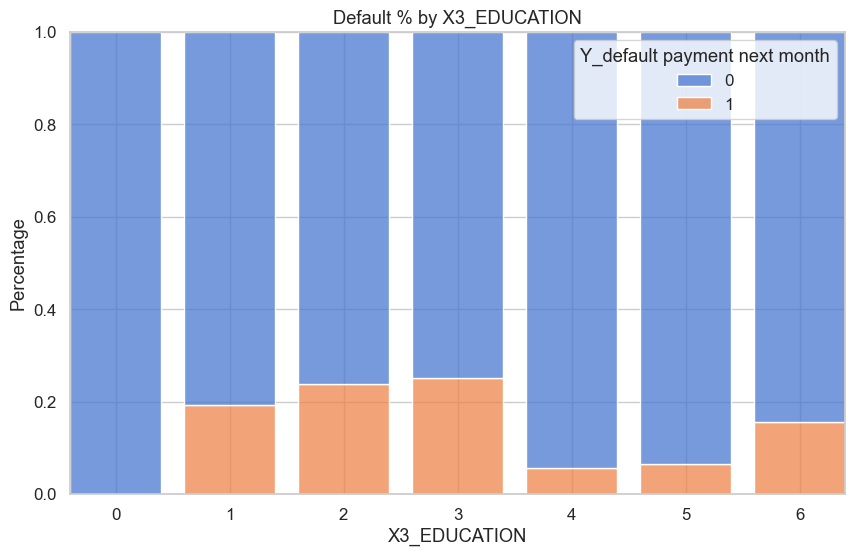

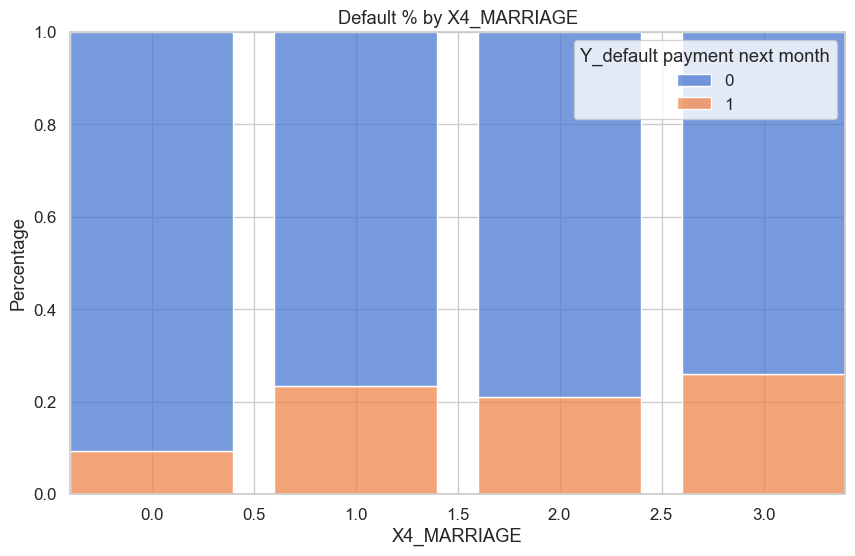

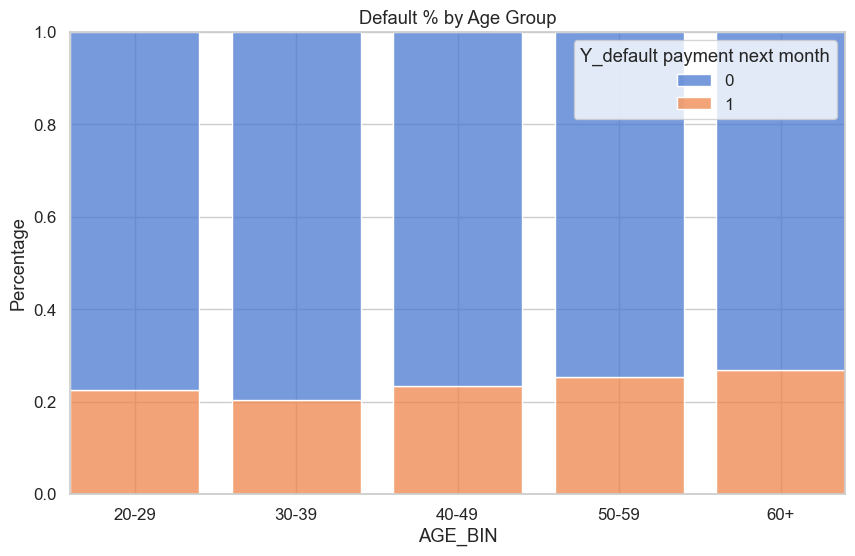

In [4]:

categorical_cols = ["X2_SEX", "X3_EDUCATION", "X4_MARRIAGE"]
for col in categorical_cols:
    sns.histplot(data=df, x=col, hue=TARGET, multiple="fill", discrete=True, shrink=0.8)
    plt.ylabel("Percentage")
    plt.title(f"Default % by {col}")
    plt.show()

# Age bins
bins = [20,30,40,50,60,80]
labels = ["20-29","30-39","40-49","50-59","60+"]
df["AGE_BIN"] = pd.cut(df["X5_AGE"], bins=bins, labels=labels)
sns.histplot(data=df, x="AGE_BIN", hue=TARGET, multiple="fill", shrink=0.8)
plt.ylabel("Percentage")
plt.title("Default % by Age Group")
plt.show()



## 5. Credit Exposure  

`X1_LIMIT_BAL` is the total credit amount assigned to a client.  

We compare the distribution between defaulters and non-defaulters. A log scale is applied because credit limits are highly skewed (some clients have extremely high limits).


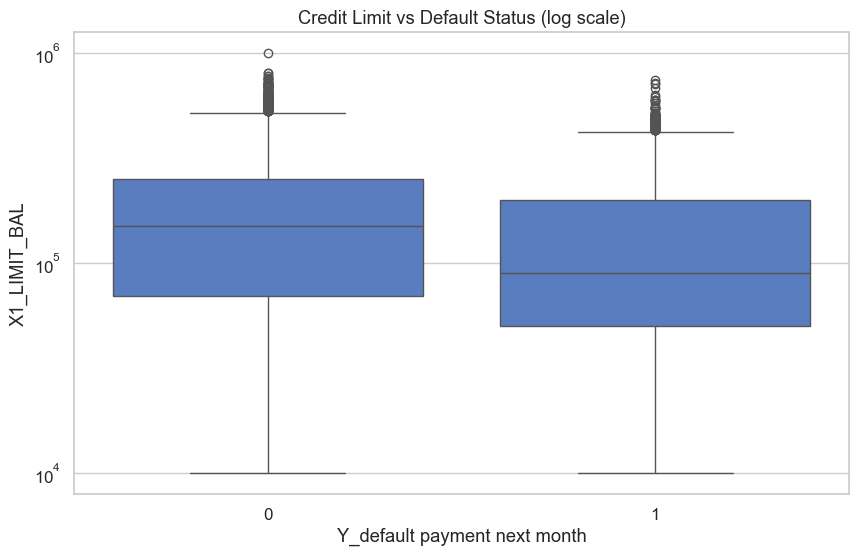

In [5]:
sns.boxplot(x=TARGET, y="X1_LIMIT_BAL", data=df)
plt.yscale("log")
plt.title("Credit Limit vs Default Status (log scale)")
plt.show()



## 6. Payment History  

Columns `X6_PAY_0` … `X11_PAY_6` track repayment status for the last 6 months.  
- -1 = paid duly, 0 = on time, 1 = delay of 1 month, 2 = delay of 2 months, …  
- Higher values = longer delays.  

We plot default percentages for each delay status. These are strong predictors of risk.


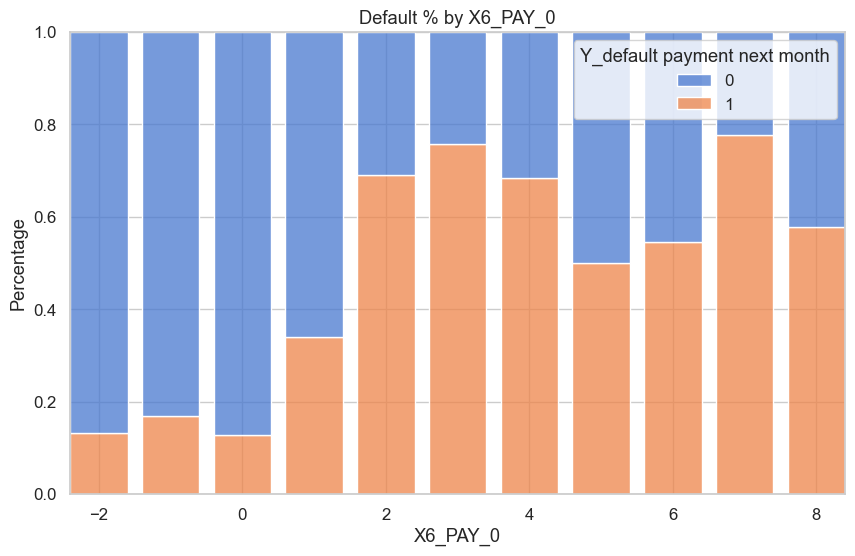

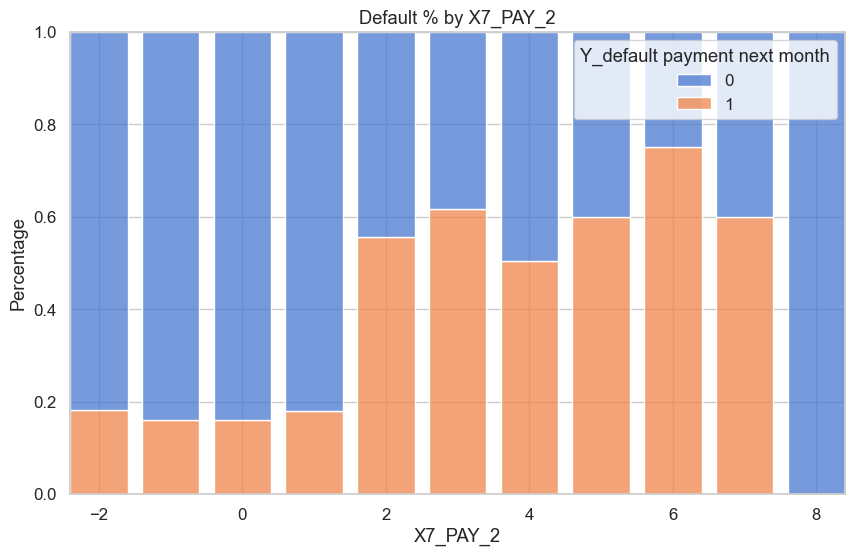

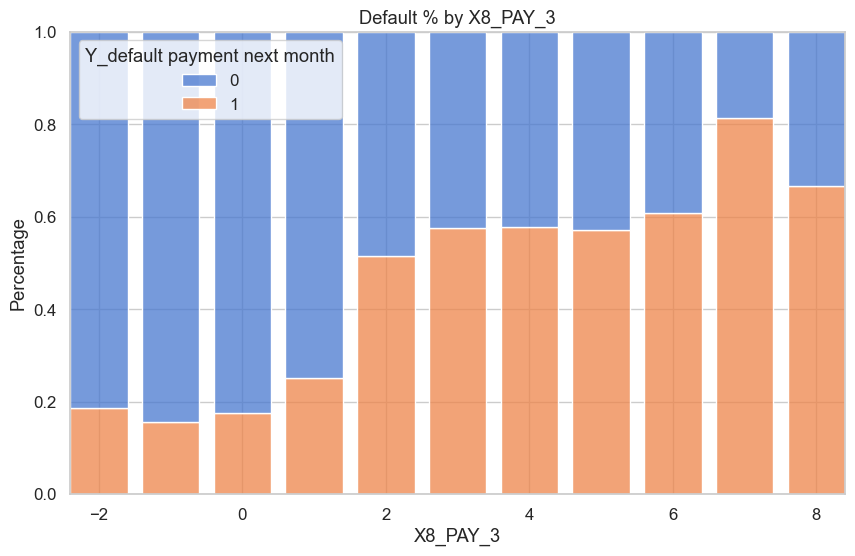

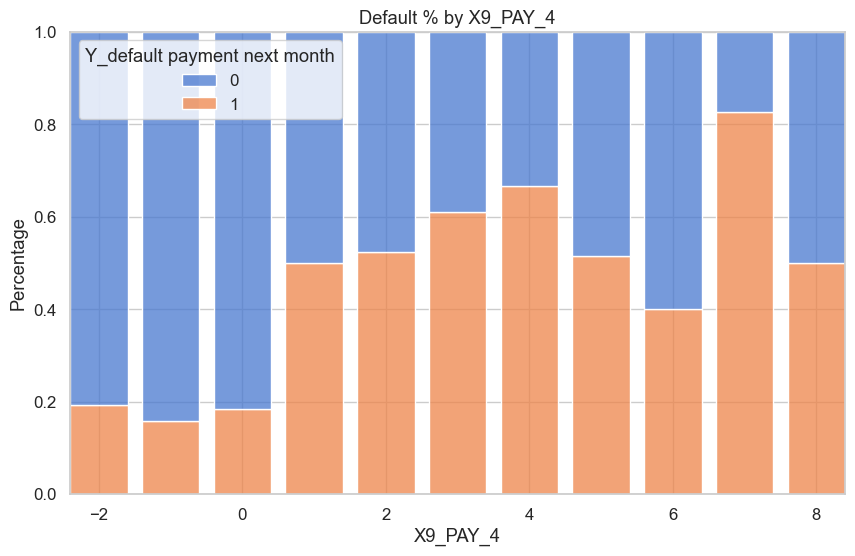

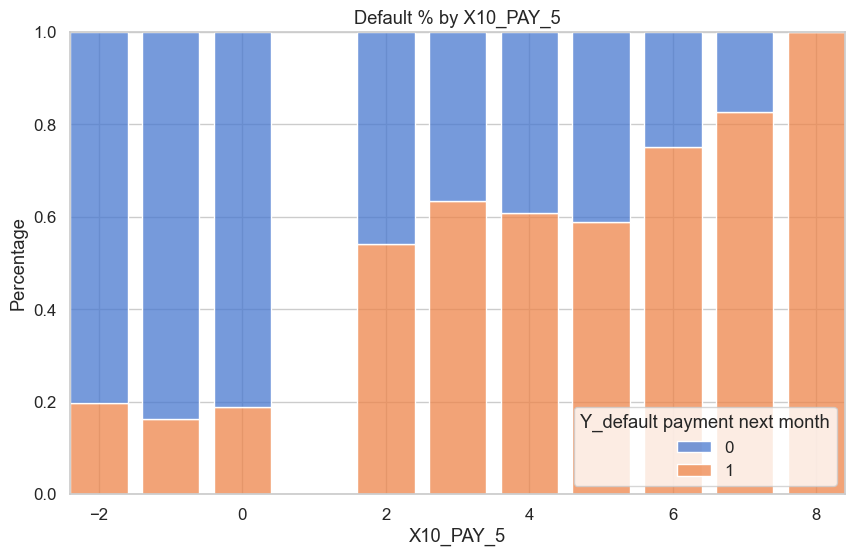

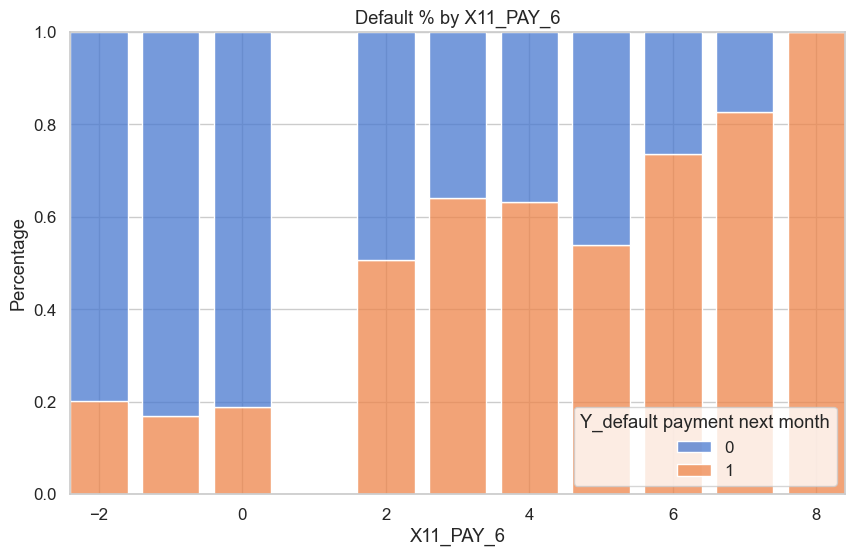

In [6]:

pay_cols = ["X6_PAY_0","X7_PAY_2","X8_PAY_3","X9_PAY_4","X10_PAY_5","X11_PAY_6"]
for col in pay_cols:
    sns.histplot(data=df, x=col, hue=TARGET, multiple="fill", discrete=True, shrink=0.8)
    plt.ylabel("Percentage")
    plt.title(f"Default % by {col}")
    plt.show()



## 7. Bill Amounts  

`X12_BILL_AMT1` … `X17_BILL_AMT6` show monthly bill amounts. These distributions are skewed with some very large balances.  
We use a log transform to make the visualization more readable.


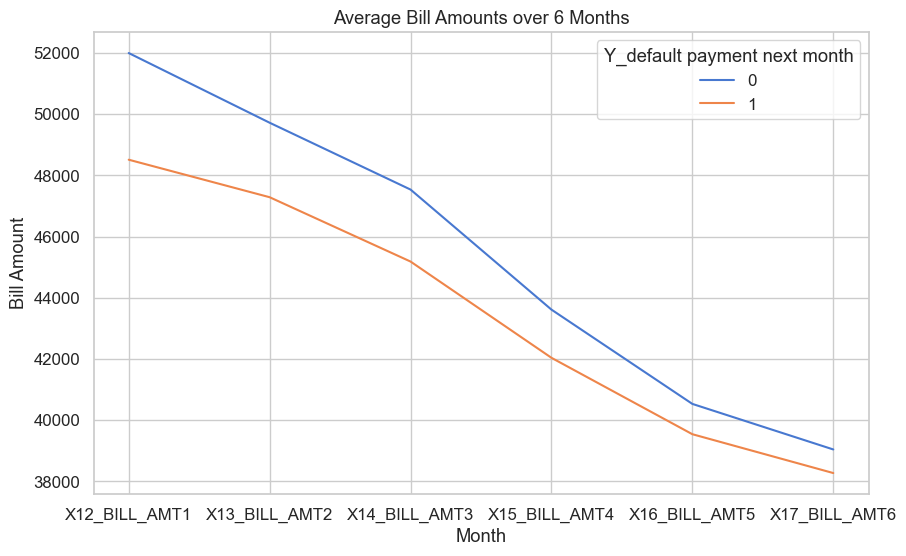

In [10]:
bill_cols = ["X12_BILL_AMT1","X13_BILL_AMT2","X14_BILL_AMT3","X15_BILL_AMT4","X16_BILL_AMT5","X17_BILL_AMT6"]

df.groupby("Y_default payment next month")[bill_cols].mean().T.plot()
plt.title("Average Bill Amounts over 6 Months")
plt.ylabel("Bill Amount")
plt.xlabel("Month")
plt.show()


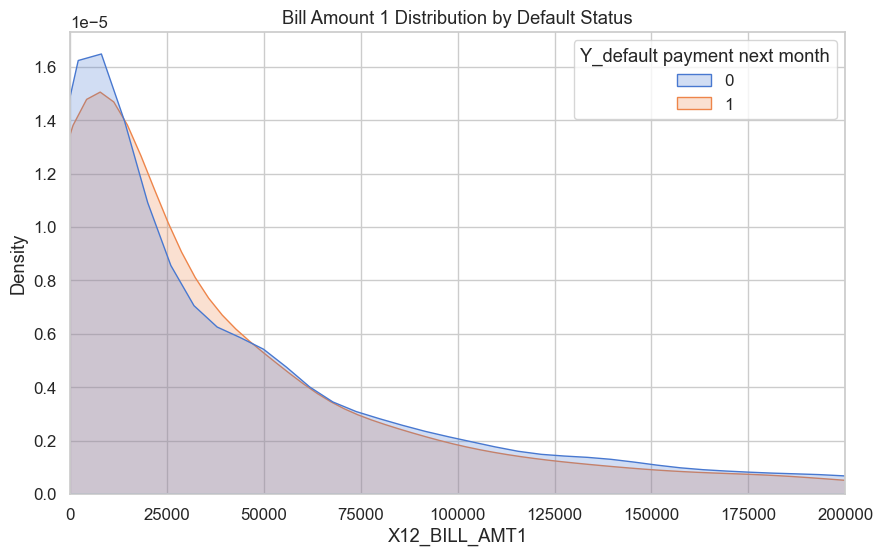

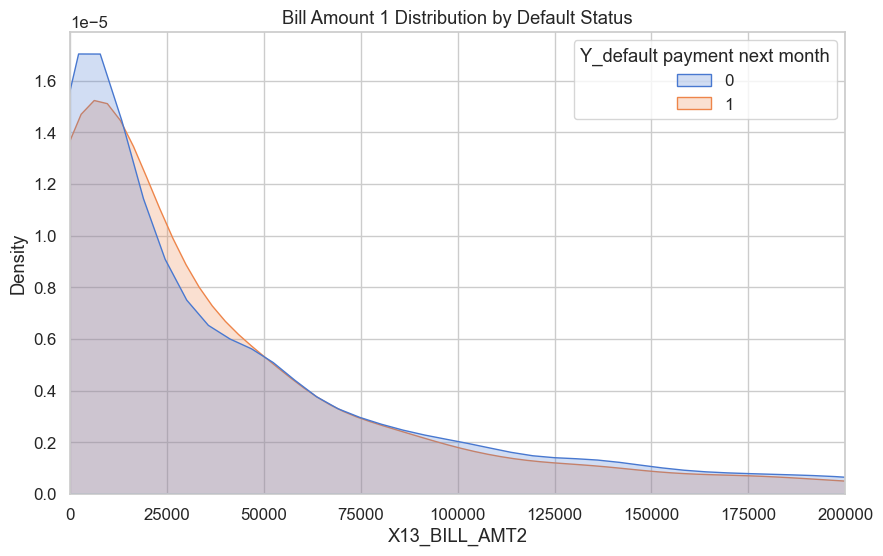

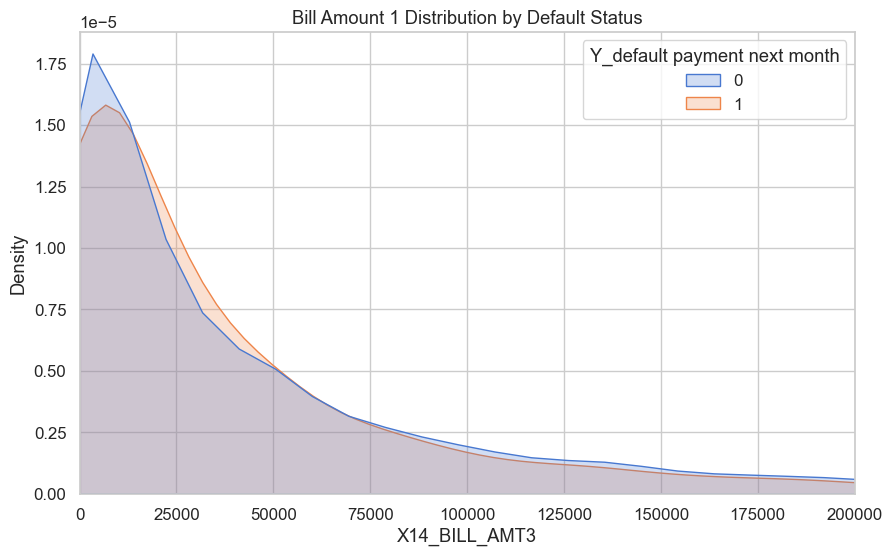

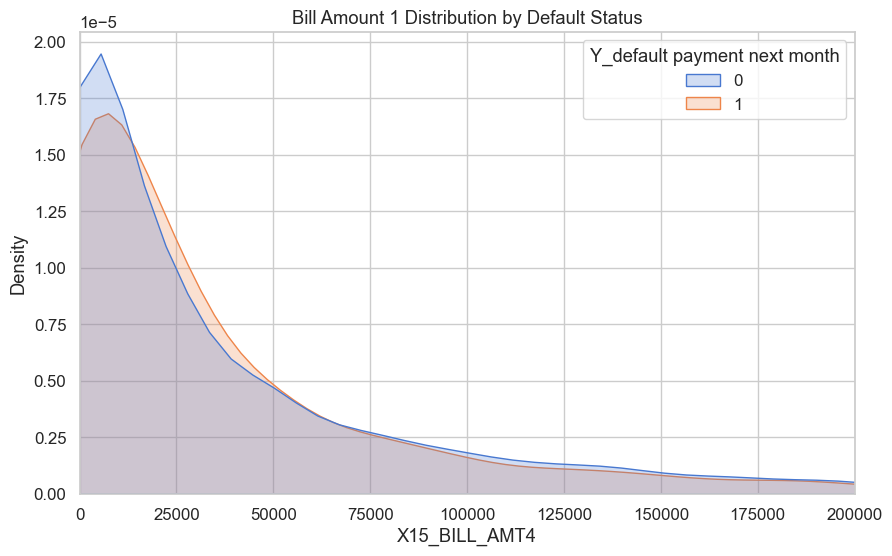

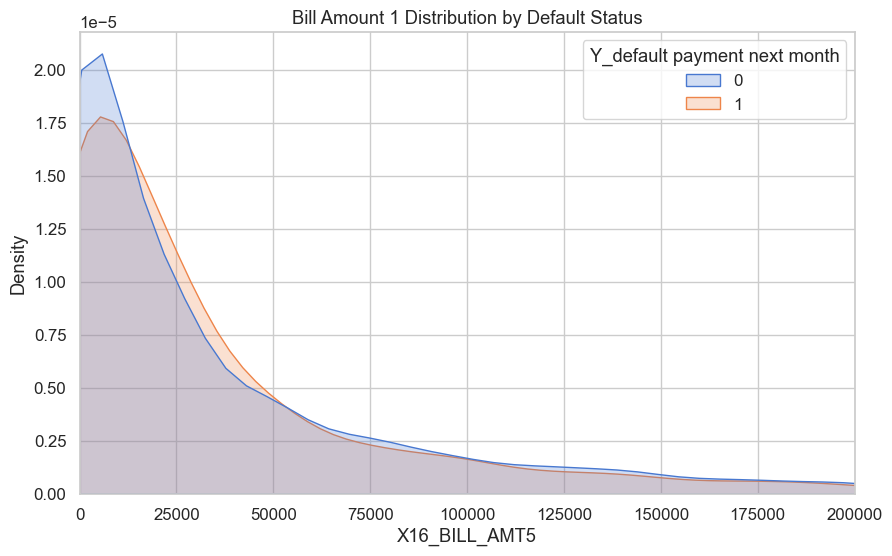

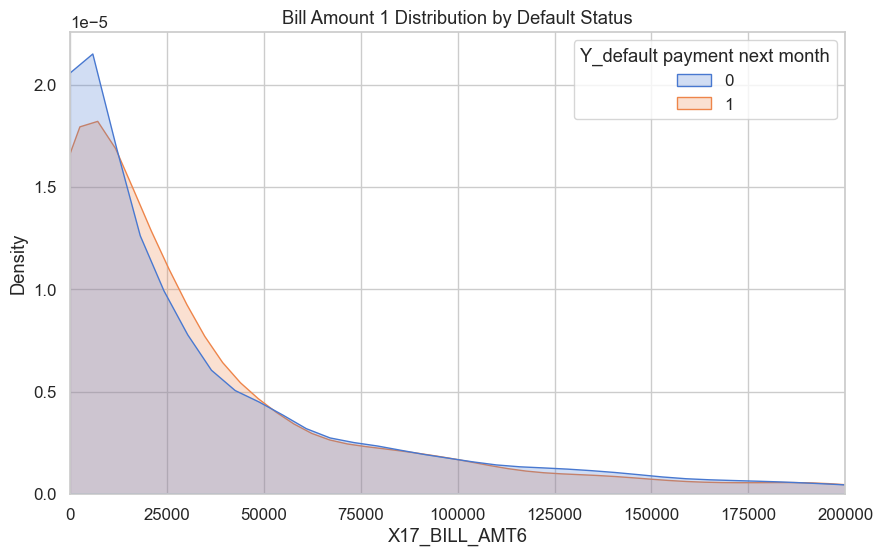

In [12]:
for col in bill_cols: 
    # sns.histplot(np.log1p(df[col]), bins=50)
    # plt.title(f"Distribution of {col} (log scale)")
    # plt.show()

    sns.kdeplot(data=df, x=col, hue="Y_default payment next month", common_norm=False, fill=True)
    plt.xlim(0, 200000)
    plt.title("Bill Amount 1 Distribution by Default Status")
    plt.show()



## 8. Payment Amounts  

`X18_PAY_AMT1` … `X23_PAY_AMT6` are amounts actually paid each month.  
We again use log scale to handle skewed values.  


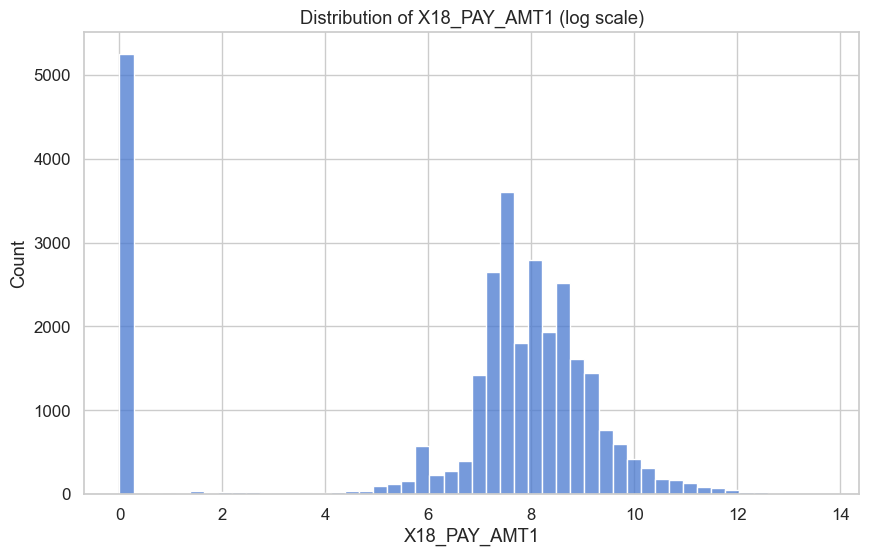

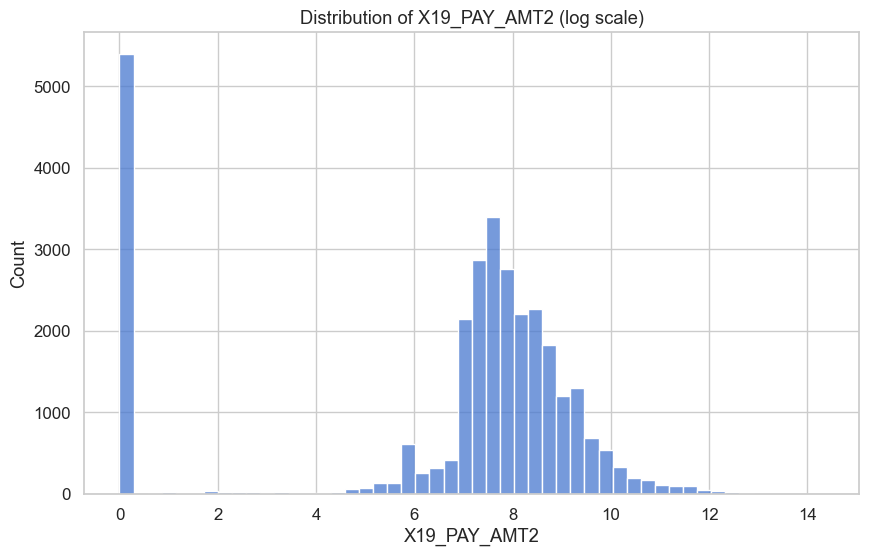

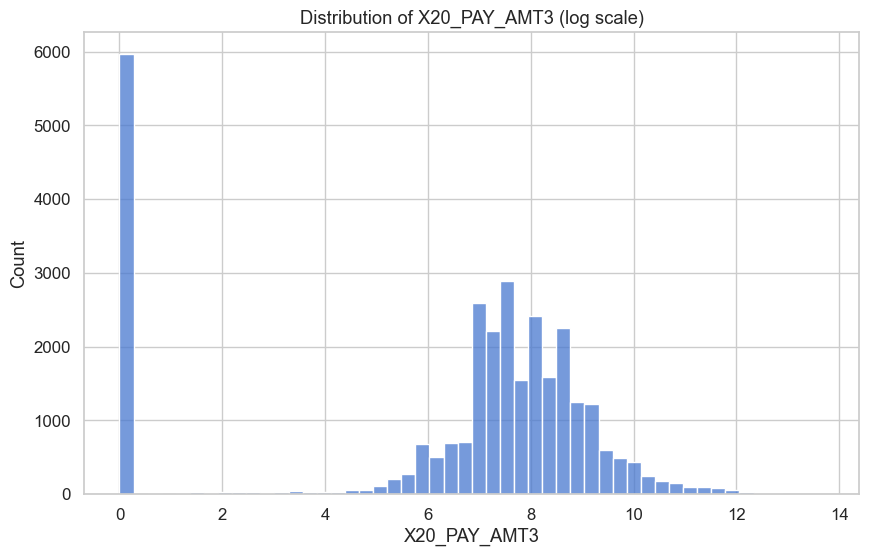

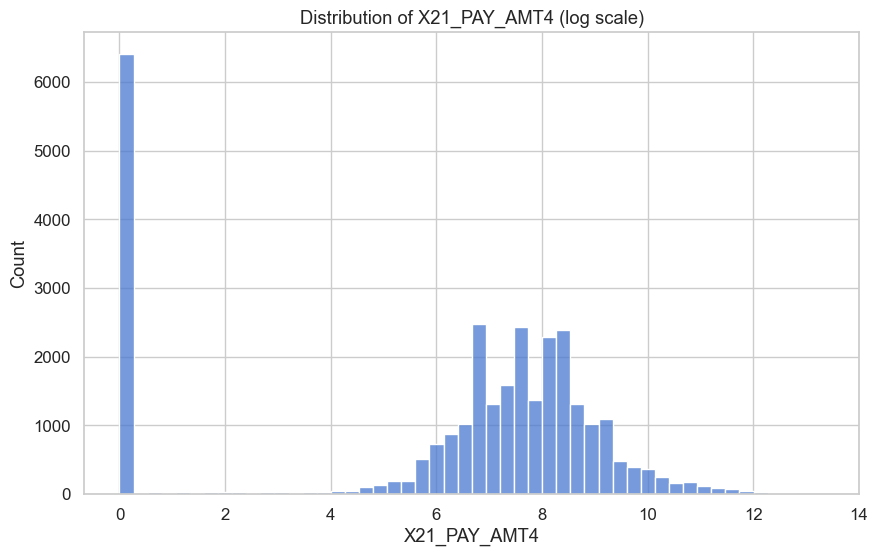

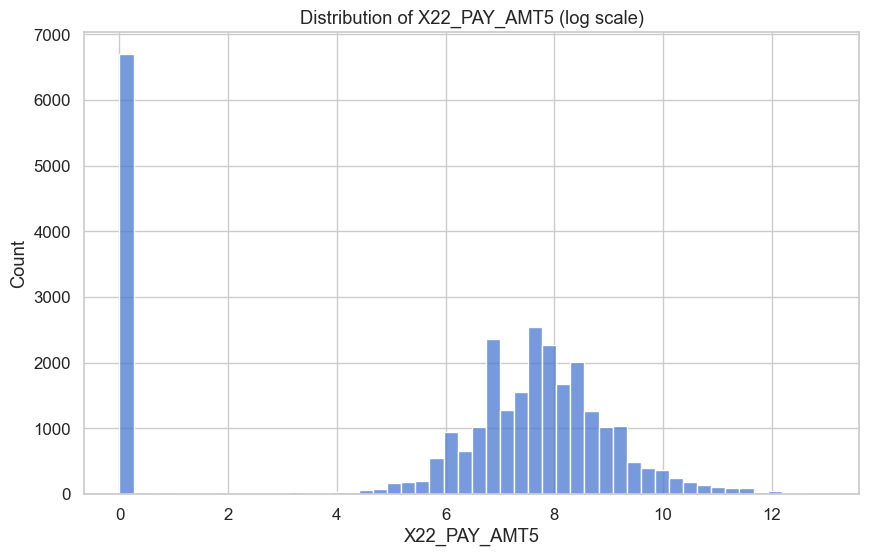

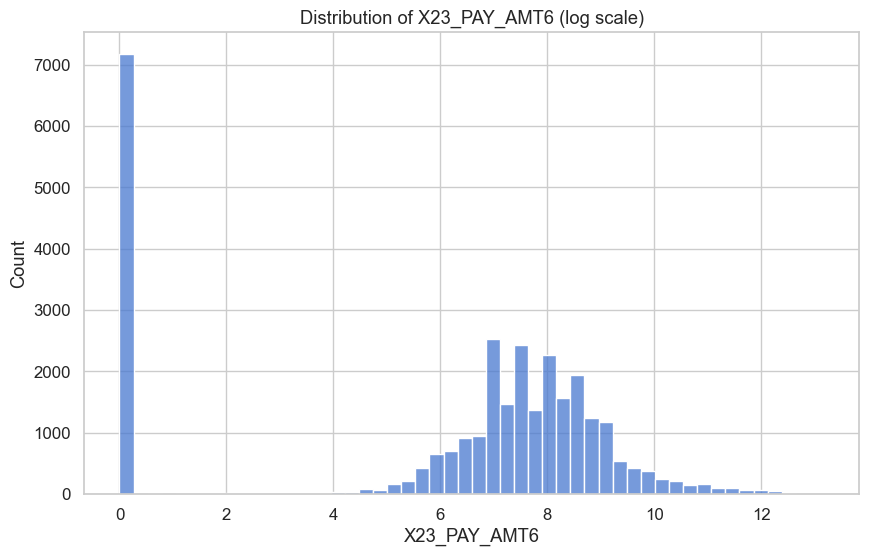

In [16]:
pay_cols = ["X18_PAY_AMT1","X19_PAY_AMT2","X20_PAY_AMT3", "X21_PAY_AMT4", "X22_PAY_AMT5", "X23_PAY_AMT6"]
for col in pay_cols:
    sns.histplot(np.log1p(df[col]), bins=50)
    plt.title(f"Distribution of {col} (log scale)")
    plt.show()



## 9. Derived Features  

To capture repayment behavior:  
- **Utilization ratio** = Bill amount ÷ Credit limit. High values = high risk exposure.  
- **Repayment ratio** = Payment ÷ Bill. Low values = underpayment.  
- **Average delay** and **Max delay** summarize payment history.  

These engineered features are often more predictive than raw amounts.


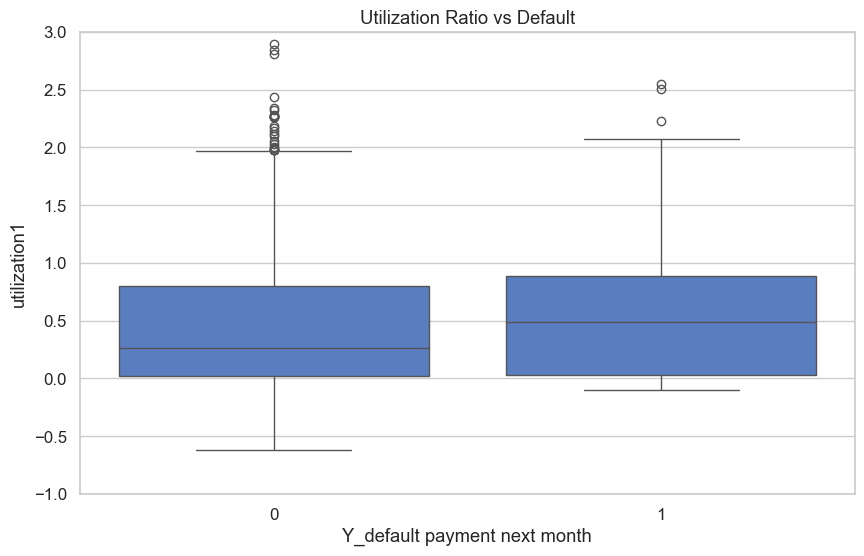

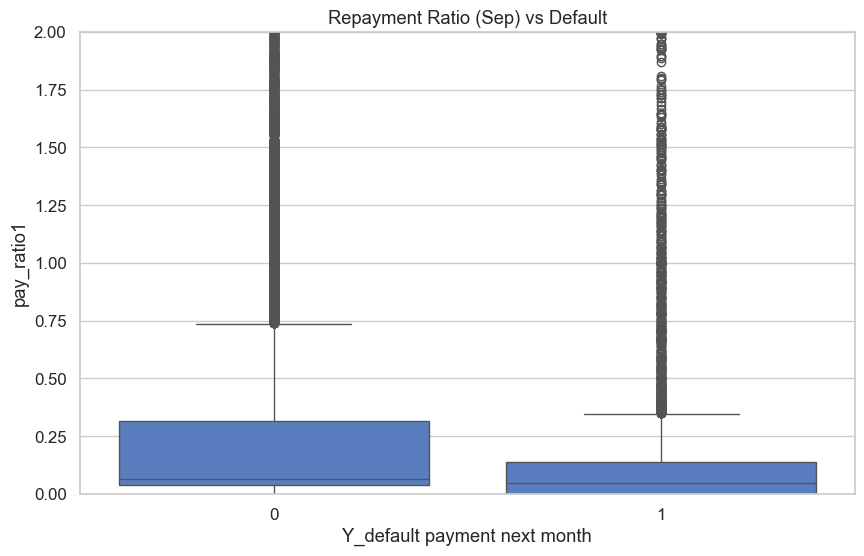

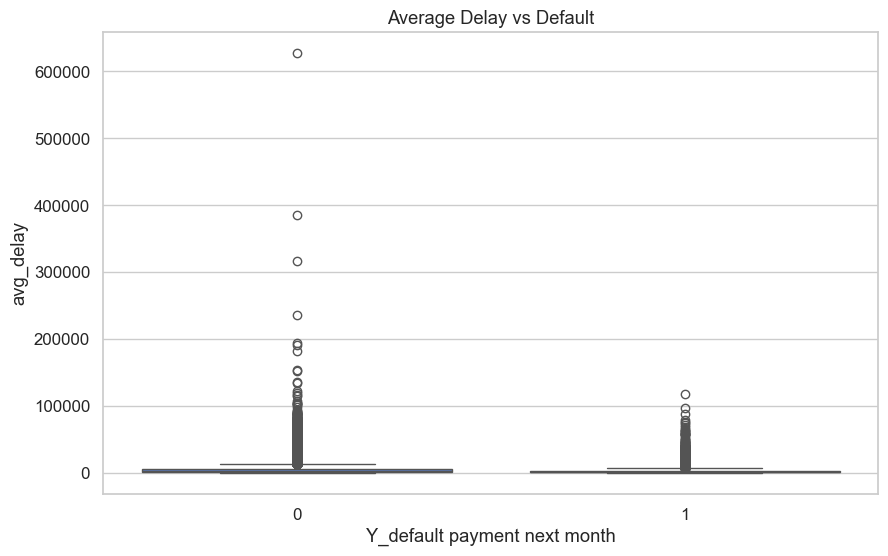

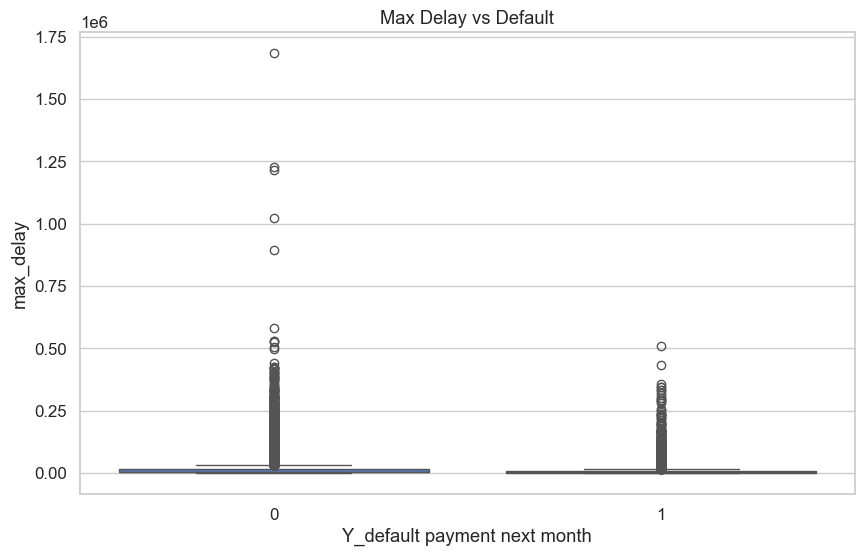

In [17]:

# Utilization ratio
df["utilization1"] = df["X12_BILL_AMT1"] / df["X1_LIMIT_BAL"]
sns.boxplot(x=TARGET, y="utilization1", data=df)
plt.ylim(-1,3)
plt.title("Utilization Ratio vs Default")
plt.show()

# Repayment ratio
df["pay_ratio1"] = df["X18_PAY_AMT1"] / df["X12_BILL_AMT1"].replace(0,np.nan)
sns.boxplot(x=TARGET, y="pay_ratio1", data=df)
plt.ylim(0,2)
plt.title("Repayment Ratio (Sep) vs Default")
plt.show()

# Avg & max delay
df["avg_delay"] = df[pay_cols].mean(axis=1)
df["max_delay"] = df[pay_cols].max(axis=1)

sns.boxplot(x=TARGET, y="avg_delay", data=df)
plt.title("Average Delay vs Default")
plt.show()

sns.boxplot(x=TARGET, y="max_delay", data=df)
plt.title("Max Delay vs Default")
plt.show()



## 10. Correlation Heatmap  

We compute correlations between numeric variables and visualize them in a heatmap.  
This helps identify which variables are strongly linked to the target or to each other (multicollinearity).


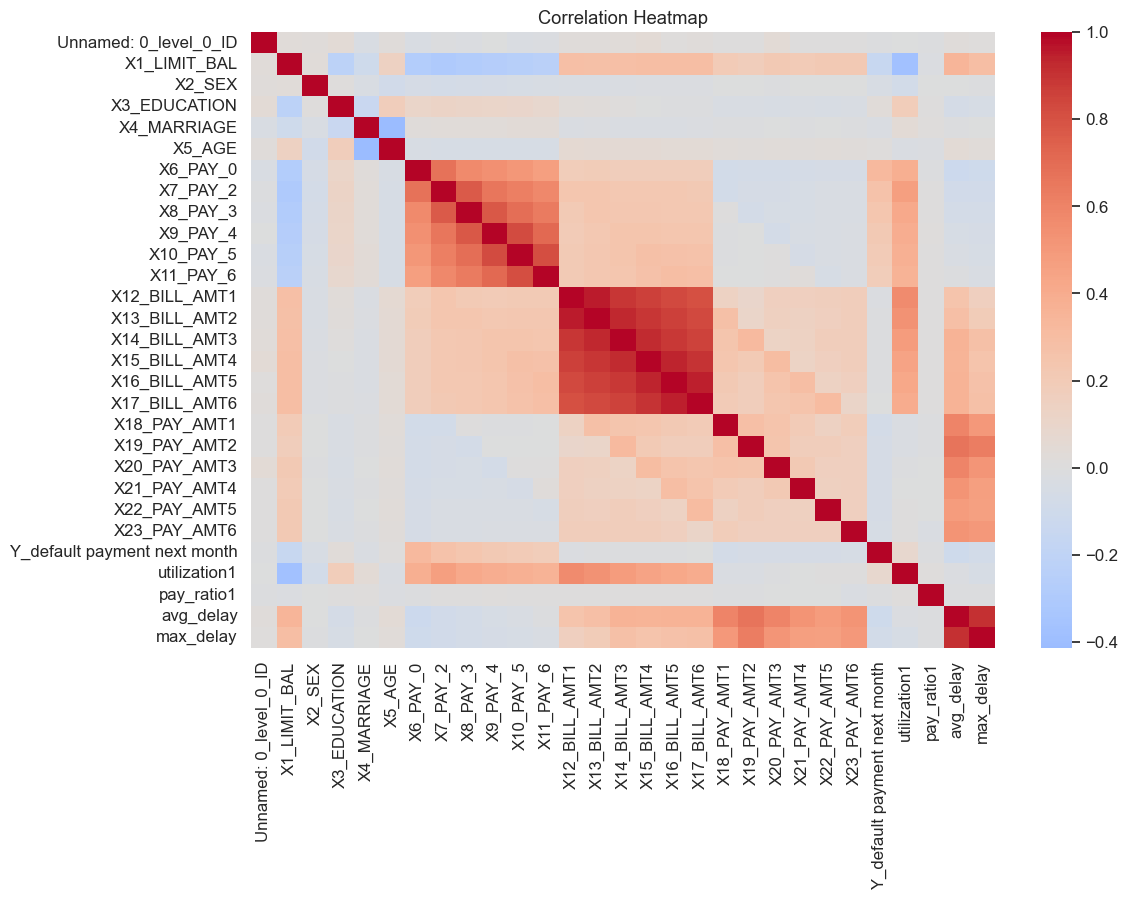

In [18]:

corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()



## 11. Outliers  

Boxplots of selected features (`LIMIT_BAL`, `BILL_AMT1`, `PAY_AMT1`) highlight extreme values.  
Outliers are common in financial data but may need special handling before modeling.


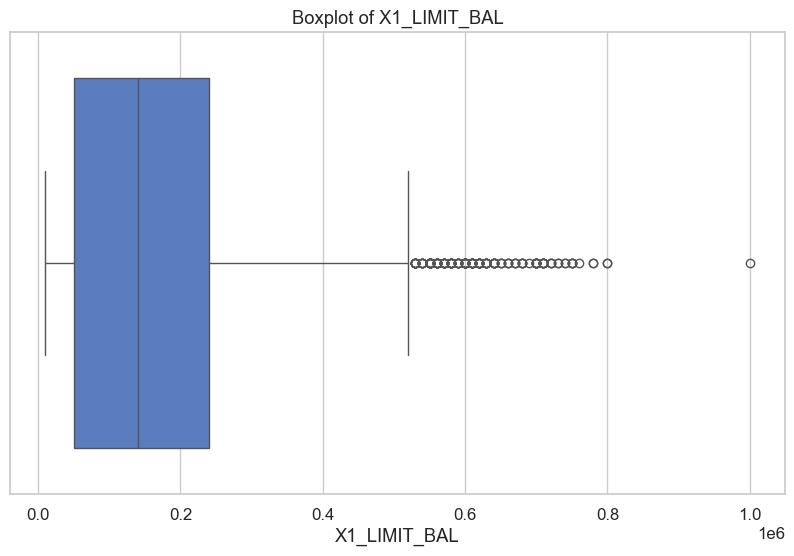

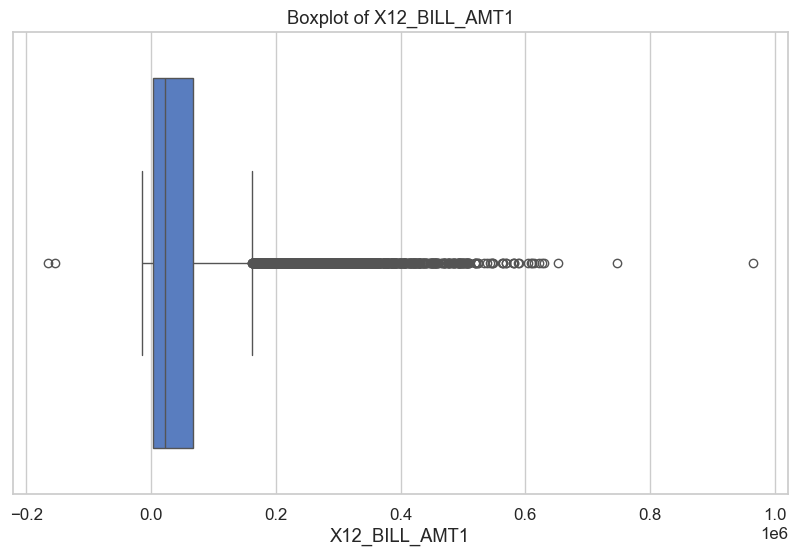

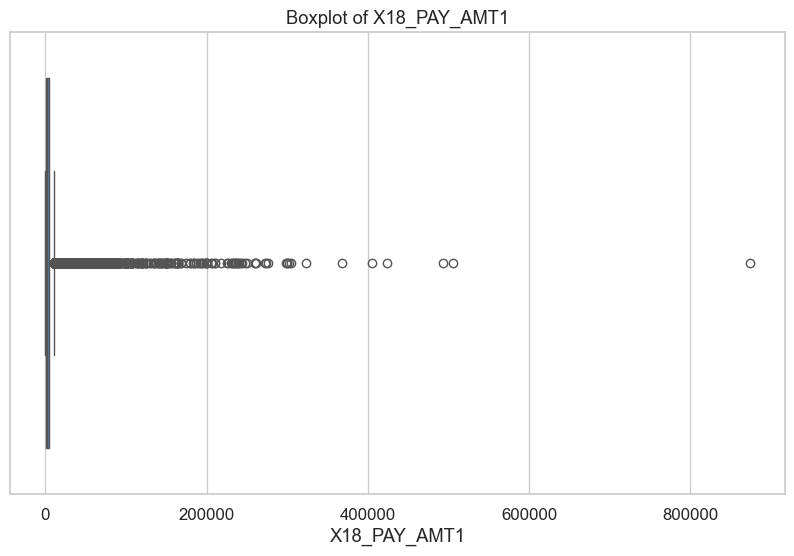

In [19]:

for col in ["X1_LIMIT_BAL","X12_BILL_AMT1","X18_PAY_AMT1"]:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()



## 12. Insights  

- Dataset is imbalanced (~22% defaults). Accuracy alone is not sufficient; precision/recall are needed.  
- Higher **payment delays** strongly correlate with defaults.  
- **Credit limit, utilization ratio, repayment ratios** provide useful separation.  
- Some **demographic groups** (low education, single) appear riskier.  
- **Bill and payment distributions** are highly skewed → log transforms recommended.  

This EDA provides a foundation for building predictive models (XGBoost, Deep Learning) and for designing features aligned with banking risk practices.
